In [1]:
# import packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import os
import datetime
import scipy.integrate
from sklearn.metrics import mean_squared_log_error

%matplotlib inline

In [2]:
# Plot for SIR Model
def plot_model_and_confirmed_cases(data, solution, area,control):
    
    t = np.linspace(1,len(data),len(data))
    
    f = plt.figure(figsize = (16,5))
    plot1 = f.add_subplot(1,2,1)
    plot1.plot(t,solution[:, 0], label = "Susceptible")
    plot1.plot(t,solution[:, 1], label = "Infected")
    plot1.plot(t,solution[:, 2], label = "Recovered")
    plot1.plot(t,solution[:,3], label = "Quarantined")
    plot1.grid()
    plot1.legend()
    plt.xlabel("Days post 500 infected")
    plt.ylabel(area + " : Number of Populations")
    plt.title("SIR Model of " + area + control+ " quarantine control")
    
    plot2 = f.add_subplot(1,2,2)
    plot2.plot(t,solution[:, 1] + solution[:, 2], label = "Predcited Comfirmed Cases")

    comfirmed_cases = []
    for cases in data["ConfirmedCases"]:
        comfirmed_cases.append(cases)
    plot2.plot(t,comfirmed_cases, label = "Comfirmed Cases")
    plot2.grid()
    plot2.legend()
    #plot2.axis([0,50,0,35000])
    plt.xlabel("Day post 500 infected")
    plt.ylabel(area + " : Number of cases")
    
    
    


In [3]:
# Data Loading
train = pd.read_csv('../COVID19/train.csv')
evalData = pd.read_csv('train-eval.csv')
train['Province_State'].fillna("",inplace = True)
evalData['Province_State'].fillna("",inplace = True)
train['Country_Region'] =  np.where(train['Province_State']!= "", train['Province_State'],train['Country_Region'])
evalData['Country_Region'] =  np.where(evalData['Province_State']!= "", evalData['Province_State'],evalData['Country_Region'])
del train['Province_State']
del evalData['Province_State']
pop_info = pd.read_csv('../COVID19/population_data.csv')
statenames = pd.read_csv('name-list.csv')


In [4]:
#CS SIRQ Model
# SIRQ Model


# Variables:
#   beta: infection rates (Different from SEIR)
#   gamma: recovery rates
#   kappa: rate of movement to quarentine
#   S: Susceptible Population
#   I: Infected Population
#   R: Recovered Population
#   Q: Quarentine Population
#   N: Total Population


# Differential Equation System
# Susceptible Equation
def SIR_dS_dt(beta, S, I, N,Q,kappa):
    return -(beta*S*I)/N-kappa*S
# Infected Equation
def SIR_dI_dt(beta, S, I, N, gamma):
    return (beta*S*I)/N - gamma*I
# Recovered Equation
def SIR_dR_dt(gamma, I):
    return gamma*I
# Quarentined Equation
def SIR_dQ_dt(kappa,S):
    return kappa*S

#dyanmic variables? Using NN...
#look into south korea - iceland - sweden
# Total Population N = S+I+R

def SIRQ_model(y, t, beta, gamma,kappa):
    # y is an array
    S,I,R,Q = y
    N = S+I+R+Q
    
    S_out = SIR_dS_dt(beta, S, I, N,Q,kappa)
    I_out = SIR_dI_dt(beta, S, I, N, gamma)
    R_out = SIR_dR_dt(gamma, I)
    Q_out = SIR_dQ_dt(kappa,S)
    return [S_out, I_out, R_out,Q_out]

# Reproduction Number
def R_t(beta,gamma):
    return beta/gamma


In [222]:
#CS SIRQ - Reverse Model
# SIRQ Model


# Variables:
#   beta: infection rates (Different from SEIR)
#   gamma: recovery rates
#   kappa: rate of movement to quarentine
#   S: Susceptible Population
#   I: Infected Population
#   R: Recovered Population
#   Q: Quarentine Population
#   N: Total Population


# Differential Equation System
# Susceptible Equation
def SIRQR_dS_dt(beta, S, I, N,Q,kappa):
    return -(beta*S*I)/N+kappa*Q
# Infected Equation
def SIRQR_dI_dt(beta, S, I, N, gamma):
    return (beta*S*I)/N - gamma*I
# Recovered Equation
def SIRQR_dR_dt(gamma, I):
    return gamma*I
# Quarentined Equation
def SIRQR_dQ_dt(kappa,Q):
    return -kappa*Q

#dyanmic variables? Using NN...
#look into south korea - iceland - sweden
# Total Population N = S+I+R

def SIRQReverse_model(y, t, beta, gamma,kappa):
    # y is an array
    S,I,R,Q = y
    N = S+I+R+Q
    
    S_out = SIRQR_dS_dt(beta, S, I, N,Q,kappa)
    I_out = SIRQR_dI_dt(beta, S, I, N, gamma)
    R_out = SIRQR_dR_dt(gamma, I)
    Q_out = SIRQR_dQ_dt(kappa,S)
    return [S_out, I_out, R_out,Q_out]

# Reproduction Number
def R_t(beta,gamma):
    return beta/gamma

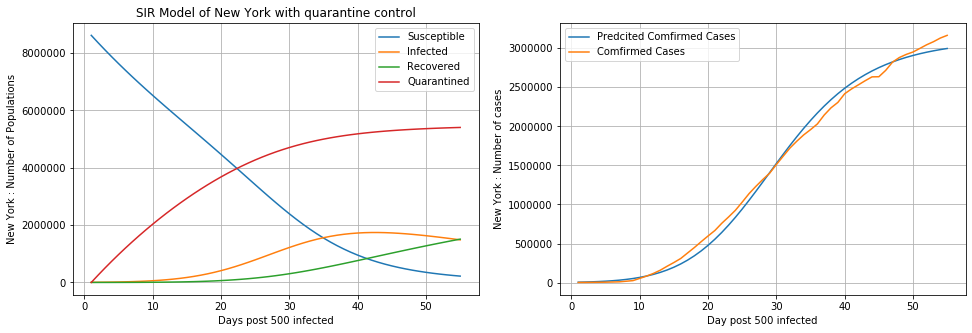

In [203]:
# The case of New York WITH Quarantine
Country = 'New York'
# Get the population
infectfactor = 10

N = pop_info[pop_info['Name']==Country]['Population'].tolist()[0]

# if area is a country
train_area = evalData[evalData['Country_Region']==Country].query('ConfirmedCases > 0')
# if area is a province/state 
if len(train_area) == 0:
    train_area = evalData[evalData['Province_State']==Country].query('ConfirmedCases > 0')

train_area['ConfirmedCases'] = train_area['ConfirmedCases'].apply(lambda x: x*infectfactor)
# Initial Condition (All values are from the paper that Ty shared)
I0 = 5000
R0 = 1
S0 = N - I0 - R0
Q0 = 0

# TODO: This parameters can be obtained by performing a local adjoint sensitivity analysis
# of ODE Problems by minimizing the mean square error loss function
# This is on page 9 of the paper that Ty shared
beta = 0.35
gamma = 0.03
kappa = 0.03

# infectfactor 20
#I0 = 12000
#beta = 0.31
#gamma = 0.03
#kappa = 0.018

# infectfactor 10
#I0 = 5000
#beta = 0.35
#gamma = 0.03
#kappa = 0.03

# infectfactor 1
#I0 = 500
#beta = 0.41
#gamma = 0.03
#kappa = 0.05

# Time vector
t = np.linspace(1,len(train_area),len(train_area))

solution = scipy.integrate.odeint(SIRQ_model,[S0,I0,R0,Q0], t ,args=(beta,gamma,kappa))
 
# plot
plot_model_and_confirmed_cases(train_area, solution, Country,' with')

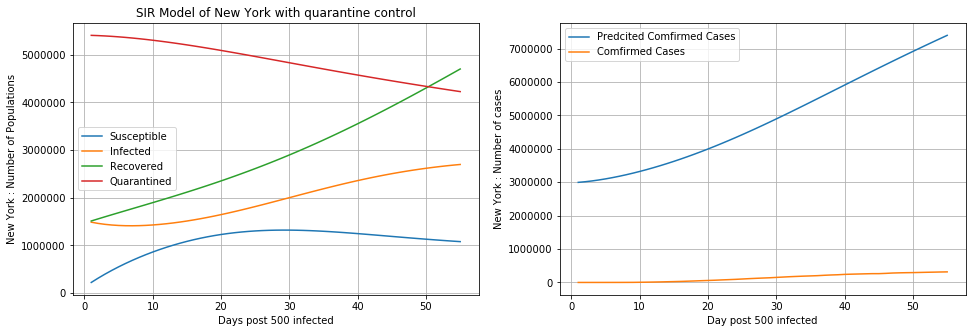

In [248]:
# The case of New York WITH Quarantine RELEASING
Country = 'New York'
# Get the population
infectfactor = 1

N = pop_info[pop_info['Name']==Country]['Population'].tolist()[0]

# if area is a country
train_area = evalData[evalData['Country_Region']==Country].query('ConfirmedCases > 0')
# if area is a province/state 
if len(train_area) == 0:
    train_area = evalData[evalData['Province_State']==Country].query('ConfirmedCases > 0')

train_area['ConfirmedCases'] = train_area['ConfirmedCases'].apply(lambda x: x*infectfactor)
# Initial Condition (All values are from the paper that Ty shared)
I0 = 1485546.91767197 
R0 = 1510563.63150418 
S0 = 220933.36662729 
Q0 = 5405956.08419658

# TODO: This parameters can be obtained by performing a local adjoint sensitivity analysis
# of ODE Problems by minimizing the mean square error loss function
# This is on page 9 of the paper that Ty shared
beta = 0.41
gamma = 0.03
kappa = 0.02

# infectfactor 20
#I0 = 12000
#beta = 0.31
#gamma = 0.03
#kappa = 0.018

# infectfactor 10
#I0 = 5000
#beta = 0.35
#gamma = 0.03
#kappa = 0.03

# infectfactor 1
#I0 = 500
#beta = 0.41
#gamma = 0.03
#kappa = 0.05

# Time vector
t = np.linspace(1,len(train_area),len(train_area))

solution = scipy.integrate.odeint(SIRQReverse_model,[S0,I0,R0,Q0], t ,args=(beta,gamma,kappa))
 
# plot
plot_model_and_confirmed_cases(train_area, solution, Country,' with')

In [193]:
print(solution[-1])
print((solution[-1][2]+solution[-1][1])/np.sum(solution[-1]))
solution[-1][2]/np.sum(solution[-1])

[ 220933.36662729 1485546.91767197 1510563.63150418 5405956.08419658]
0.34745570557533856


0.1751784334343241

8623000.0


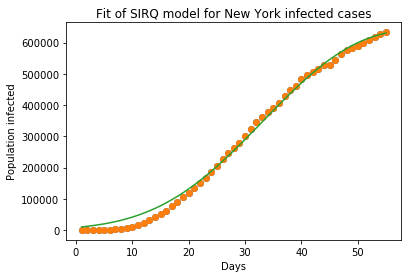

Optimal parameters: beta = 0.21120852019163552  and kappa =  0.025758934035984556
msle= 1.631682008472905


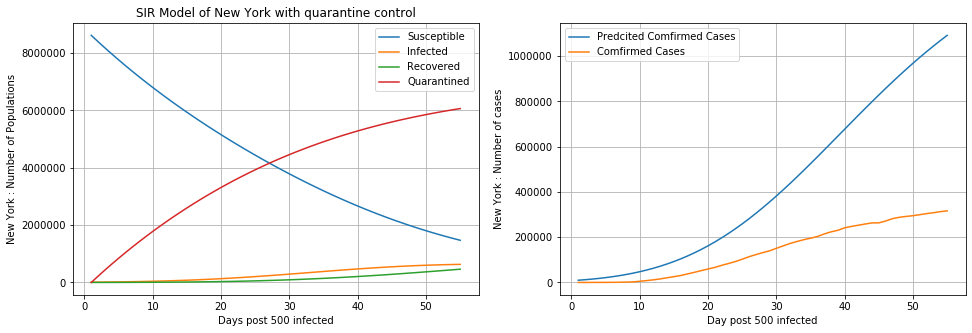

In [179]:
all_scores=[]
# Fitting the ODE using scipy.optme.curve_fit
Country = 'New York'
# Get the population
popfactor = 2

N = pop_info[pop_info['Name']==Country]['Population'].tolist()[0]
print(N)

# if area is a province/state 
train_area = evalData[evalData['Country_Region']==Country].query('ConfirmedCases > 0')

train_area['day_count'] = list(range(1,len(train_area)+1))


ydata = [i*popfactor for i in train_area.ConfirmedCases]
xdata = train_area.day_count
ydata = np.array(ydata, dtype=float)
xdata = np.array(xdata, dtype=float)

# Initial Condition (All values are from the paper that Ty shared)
I0 = 10000
R0 = 1
S0 = N - I0 - R0
Q0 = 0

gamma = 0.03

#Set up the ODE solver in a way that scipy.optimize.curve can handle
def fit_odeint(x, beta,  kappa):
    return scipy.integrate.odeint(SIRQ_model,(S0,I0,R0,Q0),x ,args=(beta,gamma,kappa))[:,1]

def fit_odeint2(x,beta, kappa):
    return scipy.integrate.odeint(SIRQ_model,(S0,I0,R0,Q0),x ,args=(beta,gamma,kappa))

#Fit the Differential equation using curve fitter
popt, pcov = scipy.optimize.curve_fit(fit_odeint, xdata, ydata, p0 = [0.2,.05])

fitted = fit_odeint(xdata, *popt)

solution = fit_odeint2(xdata,*popt)

#Set up data for evaluation, extended past training date
eval_area = evalData[evalData['Country_Region']==Country].query('ConfirmedCases > 0')
eval_area['day_count'] = list(range(1,len(eval_area)+1))
eval_data = [i*popfactor for i in eval_area.ConfirmedCases]
eval_data = np.array(eval_data, dtype=float)
eval_dates = eval_area.day_count
eval_dates = np.array(eval_dates,dtype=float)

fitted2 = fit_odeint(eval_dates,*popt)




# plot
#plot_model_and_confirmed_cases(train_area, solution, Country)
plt.plot(eval_dates, eval_data, 'o')
plt.plot(xdata,ydata,'o')
plt.plot(eval_dates, fitted2)
plt.title("Fit of SIRQ model for "+str(Country)+" infected cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt[0]," and kappa = ", popt[1])

plot_model_and_confirmed_cases(train_area, solution, Country, ' with')

#Evaluate how well the models did on new untrained data
state_eval_data = evalData[evalData['Country_Region']==Country].query('ConfirmedCases > 0')
score_c = np.sqrt(mean_squared_log_error(fitted2,state_eval_data['ConfirmedCases']))
print('msle= '+str(score_c))
all_scores.append(score_c)